In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras import Model
from keras.applications import InceptionV3
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from skimage import transform

In [3]:
BATCH_SIZE = 128
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [6]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

In [7]:
X_train = np.array([transform.resize(x, (75, 75)) for x in X_train])
X_val = np.array([transform.resize(x, (75, 75)) for x in X_val])
X_test = np.array([transform.resize(x, (75, 75)) for x in X_test])

In [8]:
base_model = InceptionV3(weights=None,
                       include_top=False,
                       input_shape=(75, 75, 3))
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [12]:
output = base_model.get_layer('average_pooling2d_2').output
output = Flatten()(output)
inception = Model(base_model.input, output)
for layer in inception.layers:
    layer.trainable = False

In [15]:
model = tf.keras.models.Sequential()
model.add(mobilenet)
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 14112)             707408    
                                                                 
 dense_7 (Dense)             (None, 64)                903232    
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 10)                330       
                                                                 
Total params: 1,613,050
Trainable params: 905,642
Non-trainable params: 707,408
_________________________________________________________________


In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [18]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [19]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [44]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1, 
                              workers=12,
                             callbacks=[EarlyStopping(monitor="val_loss",patience=5,verbose=1)])

Epoch 1/40
332/332 [==============================] - 9s 28ms/step - loss: 1.7266 - accuracy: 0.3411 - val_loss: 1.7329 - val_accuracy: 0.3408
Epoch 2/40
332/332 [==============================] - 9s 28ms/step - loss: 1.7262 - accuracy: 0.3426 - val_loss: 1.7317 - val_accuracy: 0.3394
Epoch 3/40
332/332 [==============================] - 9s 28ms/step - loss: 1.7257 - accuracy: 0.3423 - val_loss: 1.7306 - val_accuracy: 0.3425
Epoch 4/40
332/332 [==============================] - 9s 28ms/step - loss: 1.7252 - accuracy: 0.3423 - val_loss: 1.7308 - val_accuracy: 0.3409
Epoch 5/40
332/332 [==============================] - 10s 29ms/step - loss: 1.7243 - accuracy: 0.3447 - val_loss: 1.7311 - val_accuracy: 0.3400
Epoch 6/40
332/332 [==============================] - 10s 29ms/step - loss: 1.7239 - accuracy: 0.3428 - val_loss: 1.7301 - val_accuracy: 0.3444
Epoch 7/40
332/332 [==============================] - 10s 29ms/step - loss: 1.7231 - accuracy: 0.3434 - val_loss: 1.7292 - val_accuracy: 0.3

In [45]:
import pickle 

history_file_path = 'inceptionv3.pkl'

with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

print("Training history saved to:", history_file_path)

Training history saved to: inceptionv3.pkl


In [46]:
model.save("inceptionv3.keras")

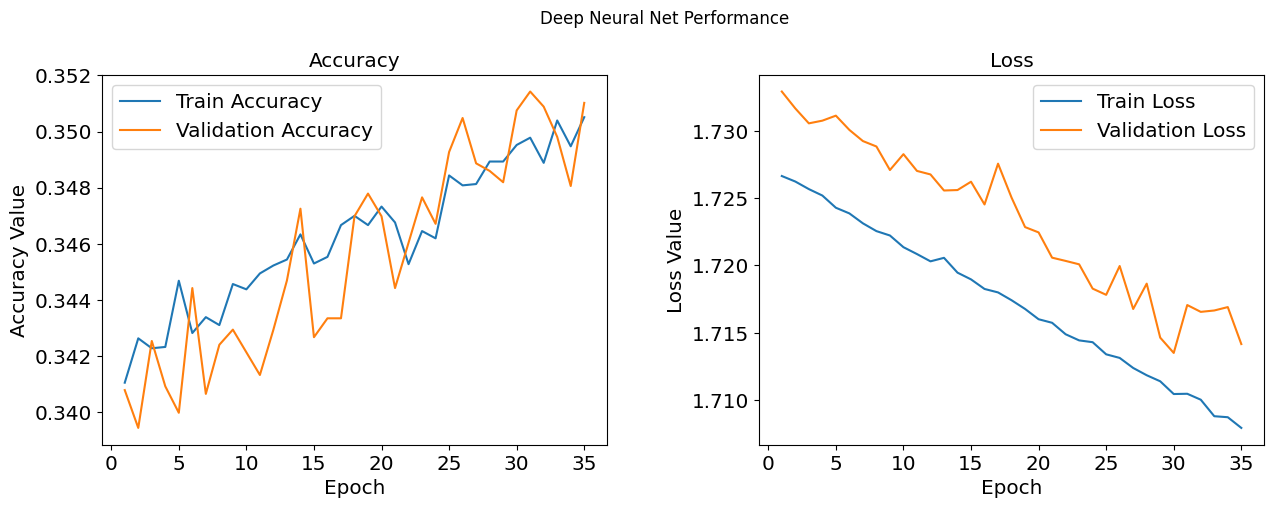

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1-5))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [49]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 2s 8ms/step


In [50]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [51]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.3541
Precision: 0.3395
Recall: 0.3541
F1 Score: 0.3365


In [52]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [53]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicited_label = np.argmax(predictions_array)
  if predicited_label == true_label:
     color = 'blue'
  else:
     colot = 'red'

  plt.xlabel("{} {:2.0f} ({})".format(label_dict[predicted_label],
                                      100*np.max(predictions_array),
                                      label_dict[true_label],
                                      color=color))

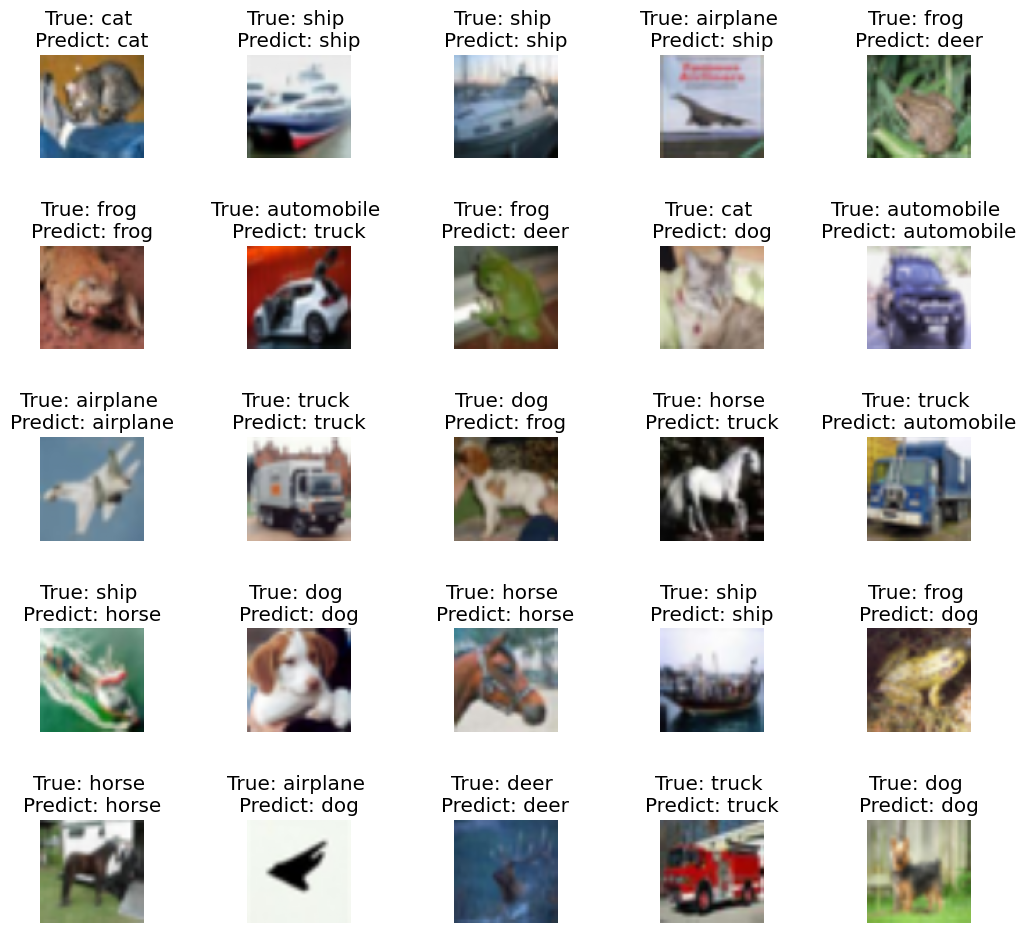

In [54]:
R = 5
C = 5

fig, ax = plt.subplots(R,C,figsize=(12,12))
ax = ax.ravel()

for i in np.arange(0, R*C):
  ax[i].imshow(X_test[i])
  ax[i].set_title("True: {} \nPredict: {}".format(label_dict[np.argmax(Y_test[i])], label_dict[predictions[i]]))
  ax[i].axis('off')
  plt.subplots_adjust(wspace=1)